# Group 4  
  
#### Jack Denker,  Nabil Kebichi,  Ansh Sehgal,  Shail Shah,  Aidan Webster
  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import geopandas
import matplotlib.pyplot as plt
from shapely.geometry import Point
from mpl_toolkits.axes_grid1 import make_axes_locatable
from functools import reduce

# Point in Time Map Analysis - (Aidan & Ansh)

### View EV Incentives by State

In [2]:
# function ot read data from csv file
def read_data(file_name):
    df = pd.read_csv(file_name)
    return df

In [3]:
# main function
def main():

    df = read_data('incentives.csv')
    # select rows where fuel type code is ELEC
    
    plt.figure(figsize=(12, 5))

    # count number of rows for each state in the dataframe
    df = df.groupby('State').size()
    df.sort_values(ascending=False, inplace=True)

    df.plot(kind='bar')
    plt.title('EV Incentives by State')
    plt.ylabel('Number of EV Incentives')
    plt.xlabel('State')
    plt.bar(df.index, df.values, width=0.5)
    plt.show()

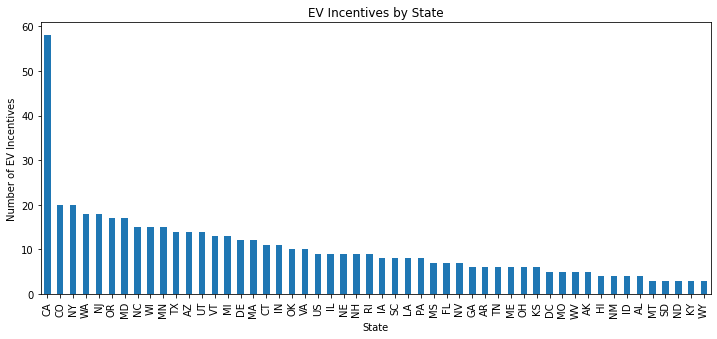

In [4]:
main()

### Import data, create state DataFrame with: 
 - Median income  
 - GDP
 - largest Industry
 - EV registrations  
 - Total population  
 - Total Area (sq miles)  
 - Geographic coordinates  

In [5]:
# start by populating a df with census data by state
# https://www.census.gov/data/tables/time-series/demo/income-poverty/historical-income-households.html

state_median = pd.read_excel('median_income_state.xlsx', header=(62,63))

In [6]:
# clean state_median df, clean headers and remove duplicate years
headers = []
drop = []

for year in range(1984, 2021):
    headers.append(year)
    
for header in state_median:
    if type(header[0]) == str and header[0] != 'State':
        new_header = int(header[0][:4])
        
        if new_header in headers:
            drop.append(header)
            state_median.drop([header], axis=1, inplace=True)
        else:
            state_median.rename(columns={header[0] : new_header}, inplace=True)

# create new df with only states and 2020 median income data
states = state_median['State']['Unnamed: 0_level_1']
median2020 = state_median[2020]['Median income']
frame = { 'State': states, '2020 Median Income': median2020 }
state_median2020 = pd.DataFrame(frame)

In [7]:
# https://apps.bea.gov/itable/iTable.cfm?ReqID=70&step=1&acrdn=1
gdp = pd.read_csv('states_gdp.csv', header=4)
gdp.rename(columns={"GeoName": "State", '2020': '2020 GDP'}, inplace=True)
gdp.drop('GeoFips', axis=1, inplace=True)

In [8]:
# https://overheardonconferencecalls.com/business/largest-industry-each-state/
industry = pd.read_csv('bea_industry_data.txt', sep='\t')
industry.drop(['Largest Industry Monetary Contribution (USD, in millions)', 
               'Largest Industry GDP %', '5-Year Change in % of Largest Industry'], axis=1, inplace=True)

In [9]:
# data on EV registrations by state
# https://afdc.energy.gov/data/10962
evreg_state = pd.read_excel('10962-ev-registration-counts-by-state_6-11-21.xlsx', 
                            header=(2), usecols=['State', 'Registration Count'])
evreg_state.rename(columns={"Registration Count": "EV Registration Count"}, inplace=True)

In [10]:
# census data on state populations in 2019 (most recent year)
# https://data.census.gov/cedsci/table?q=Total%20Population&g=0100000US%240400000&tid=ACSDP1Y2019.DP05
state_pop = pd.read_excel('ACSDP1Y2019.DP05-2021-12-05T182017.xlsx', 'Data')

# remove repeat instances of Total population LI by taking only top 5 rows
state_pop = state_pop.head(5)
state_pop = state_pop.T # transpose data to match merged df
new_header = state_pop.iloc[0] # take first row to be new header
state_pop = state_pop[1:] # new data minus first row (new header)
state_pop.columns = new_header
state_pop.drop(['Label', 'SEX AND AGE', 'Male', 'Female'], axis=1, inplace=True) # drop all irrelevent data
state_pop.reset_index(inplace=True)
state_pop.rename(columns={"index": "State"}, inplace=True) # rename columns to match naming conventions
state_pop['Total population'] = state_pop['Total population'].str.replace(',', '').astype(int) # remove columns, str to int

In [11]:
# import state area from tsv file
# https://www.census.gov/geographies/reference-files/2010/geo/state-area.html

state_coord_area = pd.read_csv('census_state_data.txt', sep='\t', names=['State', 'Square Miles', 'total Sq. Km.', 'land Sq. Mi.', 
                                  'land Sq. Km.', 'water Sq. Mi.', 'water Sq. Km.', 'inland Sq. Mi.',
                                  'inland Sq. Km.', 'coastal Sq. Mi.', 'coastal Sq. Km.', 'gl Sq. Mi.', 
                                  'gl Sq. Km.', 'territorial Sq. Mi.', 'territorial Sq. Km.', 'Latitude', 'Longitude'])

state_coord_area.drop(['total Sq. Km.', 'land Sq. Mi.','land Sq. Km.', 'water Sq. Mi.', 
                       'water Sq. Km.', 'inland Sq. Mi.', 'inland Sq. Km.', 'coastal Sq. Mi.', 'coastal Sq. Km.', 
                       'gl Sq. Mi.', 'gl Sq. Km.', 'territorial Sq. Mi.', 'territorial Sq. Km.', 'Latitude', 'Longitude'], 
                        axis=1, inplace=True)

,State,Square Miles
57,U.S. Virgin Islands,733


In [12]:
data_frames = [state_median2020, gdp, industry, evreg_state, state_pop, state_coord_area]
state_info = reduce(lambda  left,right: pd.merge(left,right,on='State', how='inner'), data_frames)

In [13]:
# calculated fields for EV registrations per capita and per sq mile to add context to EV numbers
state_info['EV Registations per $1000000 GDP'] = state_info['EV Registration Count'] / state_info['2020 GDP'] * 1000
state_info['EV Registations per 1000'] = state_info['EV Registration Count'] / state_info['Total population'] * 1000
state_info['Square Miles'] = state_info['Square Miles'].str.replace(',', '').astype(int)
state_info['EV Registations per sq mile'] = state_info['EV Registration Count'] / state_info['Square Miles']

In [14]:
# for state map grapping, we want to drop Alaska, and Hawaii
continental_us_info = state_info.drop([1,10])
# create new df without California which appears to be a huge outlier on EV registrations
without_california = continental_us_info.drop([4])

### Mapping

In [15]:
states = geopandas.read_file('shapes/shapefile.shx')
states = states[['NAME','STUSPS','geometry']]
states = states.rename(columns={'NAME':'State'})
state_geo = pd.merge(states, continental_us_info, on='State')
state_geo_noCA = pd.merge(states, without_california, on='State')

In [16]:
def geo_map(data, data_column, title):
    fig, ax = plt.subplots(1, figsize=(10, 10)) # create figure, set size to 10x10
    ax.axis('off') # turn off axis ticks as geo axis aren't useful
    ax.set_title(title, fontdict={'fontsize': '15', 'fontweight' : '2'}) # title from function call
    divider = make_axes_locatable(ax) # use make_axis_locatable function to allow manipulation of legend
    cax = divider.append_axes("right", size="2%", pad=0.1)
    data.plot(column=data_column, linewidth=0.8, edgecolor='0.8', ax=ax, cax=cax, cmap='Greens', legend=True)

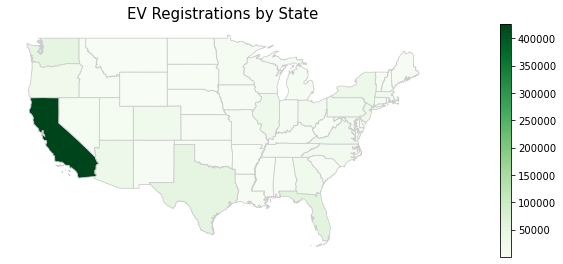

In [17]:
geo_map(state_geo, 'EV Registration Count', 'EV Registrations by State')

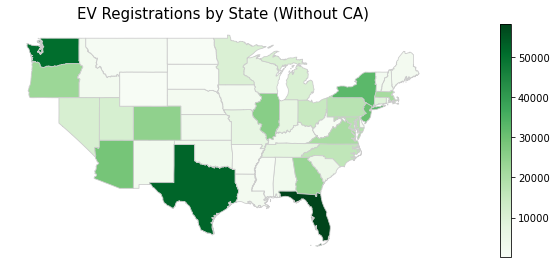

In [18]:
geo_map(state_geo_noCA, 'EV Registration Count', 'EV Registrations by State (Without CA)')

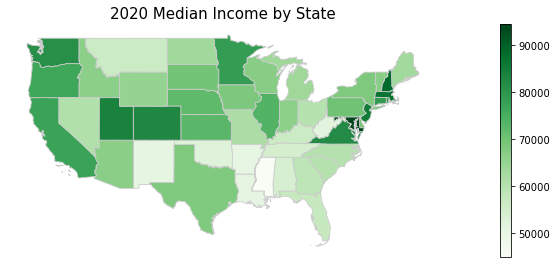

In [19]:
geo_map(state_geo, '2020 Median Income', '2020 Median Income by State')

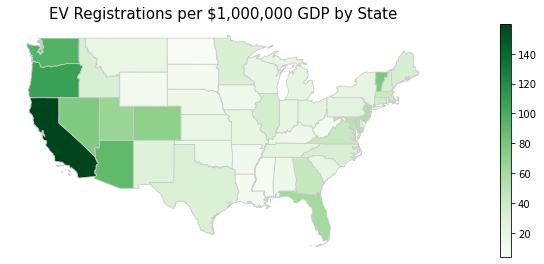

In [20]:
geo_map(state_geo, 'EV Registations per $1000000 GDP', 'EV Registrations per $1,000,000 GDP by State')

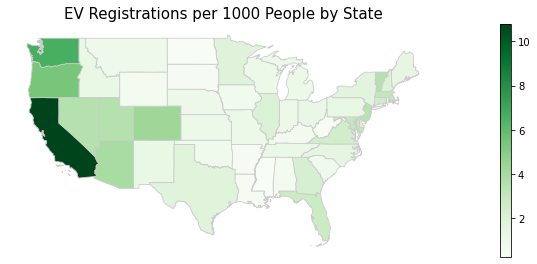

In [21]:
geo_map(state_geo, 'EV Registations per 1000', 'EV Registrations per 1000 People by State')

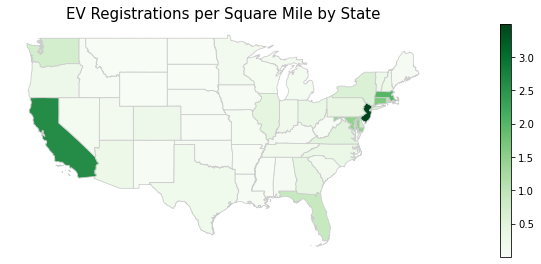

In [22]:
geo_map(state_geo, 'EV Registations per sq mile', 'EV Registrations per Square Mile by State')

<AxesSubplot:title={'center':'Largest Industry by State'}>

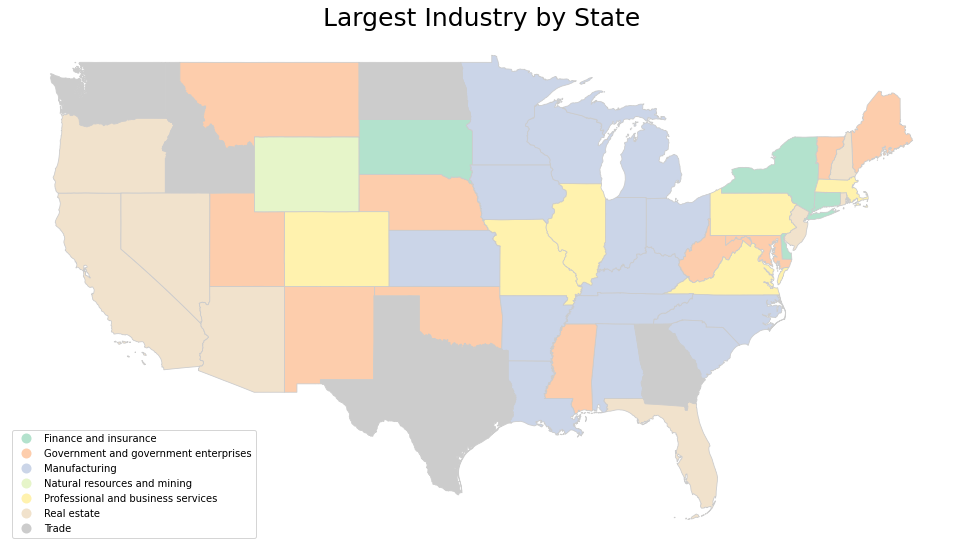

In [23]:
fig, ax = plt.subplots(1, figsize=(17, 17)) # create figure, set size to 10x10
ax.axis('off') # turn off axis ticks as geo axis aren't useful
ax.set_title('Largest Industry by State', fontdict={'fontsize': '25', 'fontweight' : '2'}) # title from function call
state_geo.plot(column='Largest Industry', linewidth=0.8, edgecolor='0.8', ax=ax, 
               cmap='Pastel2', legend=True, legend_kwds={'loc': 'lower left'})

# Overtime Map Analysis - (Ansh & Aidan)

In [24]:
ev_2012 = pd.read_csv('stations_2012.csv')
ev_2014 = pd.read_csv('stations_2014.csv')
ev_2021 = pd.read_csv('stations_2021.csv')

ev_2012 = ev_2012[ev_2012['Fuel Type Code'] == 'ELEC']
ev_2014 = ev_2014[ev_2014['Fuel Type Code'] == 'ELEC']
ev_2021 = ev_2021[ev_2021['Fuel Type Code'] == 'ELEC']

/Users/aidanwebster/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (3,6,10,13,14,15,16,20,29,31,33,34,35,36,43,45,46,47,49,52,53,54,56,57,58,59,60,61,62,63) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [25]:
def geo_time_series(data, title):
    
    gdf = geopandas.GeoDataFrame(data, geometry=geopandas.points_from_xy(data.Longitude, data.Latitude))
    
    ax = state_geo.plot(color='white', edgecolor='black', figsize=(20, 20))
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '2'}) # title from function call
    ax.axis('off')
    gdf.plot(ax=ax, color='green',marker='o', markersize=6, figsize=(20, 20))

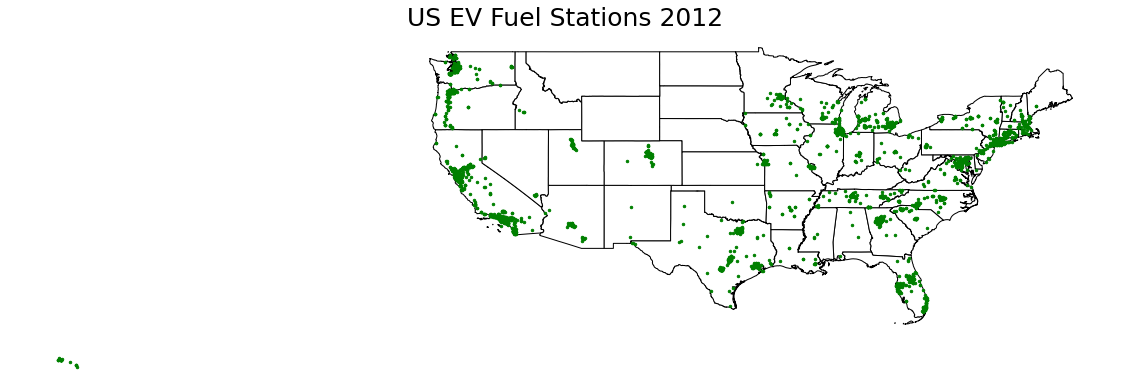

In [26]:
geo_time_series(ev_2012, 'US EV Fuel Stations 2012')

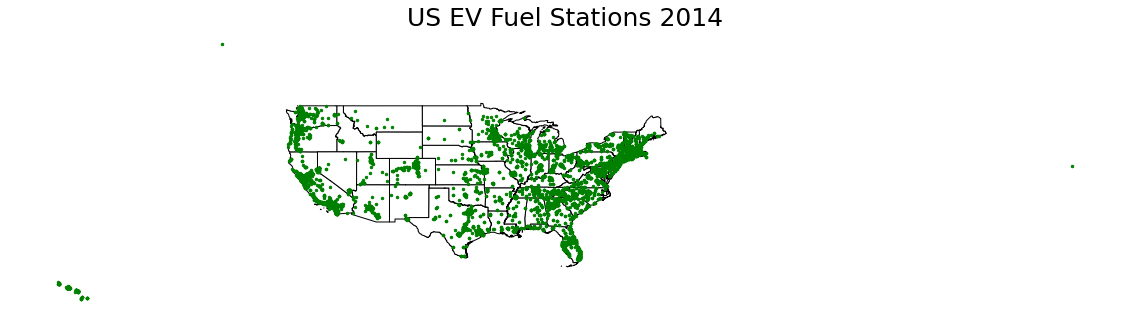

In [27]:
geo_time_series(ev_2014, 'US EV Fuel Stations 2014')

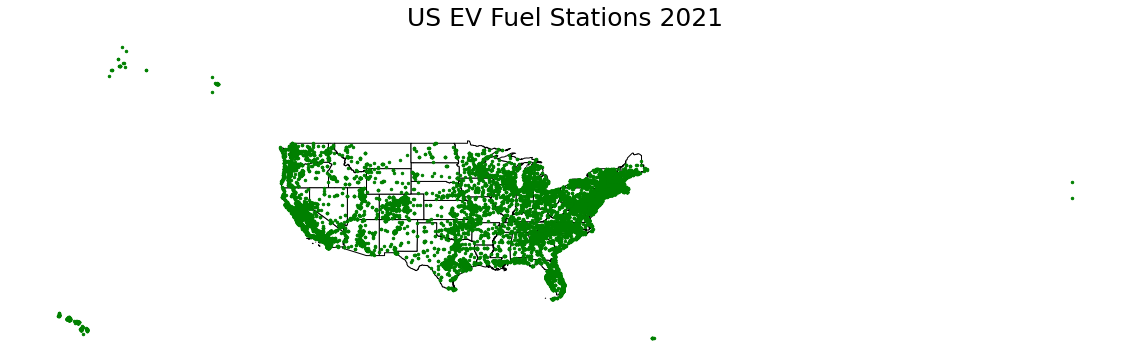

In [28]:
geo_time_series(ev_2021, 'US EV Fuel Stations 2021')

# Model Trend Analysis - (Shail)

In [29]:
sale_data = pd.read_csv('ev_sale_data.csv')
pivot_df = sale_data.pivot(index='Year', columns='Model', values='Count')
named_pivot_df = pivot_df.loc[:,['Chevy Volt','Nissan Leaf','Smart ED','Mitsubishi I EV','BMW Active E','Prius PHEV','Ford Focus EV','Honda Fit EV',
                'Tesla Model S','Toyota RAV4 EV','Ford C-Max Energi','Honda Accord','Ford Fusion Energi','Chevy Spark','Fiat 500E',
                'Porsche Panamera S E-Hybrid','Cadillac ELR','BMW i3','Mercedes B-Class (B250e)','BMW i8','VW e-Golf','Kia Soul EV',
                'Porsche Cayenne S E-Hybrid','Mercedes S550 Plug', 'Volvo-XC90 Plug In', 'Tesla Model X','BMW X5', 'Hyundai Sonata Plug In',
                'Audi A3 Plug In', 'BMW 3-series Plug-In', 'Mercedes GLE 550e', 'BMW 7-series Plug-in', 'Mercedes C350We','Chevy Bolt',
                'Kia Optima Plug-in','Hyundai Ioniq EV','Chrysler Pacifica Plug-in Hybrid','Cadillac CT6','BMW 5-Series Plug in','MINI Countryman S E',
                'Porsche Panamera 4 E-H', 'Tesla Model 3','Honda Clarity BEV', 'Volvo XC60 Plug In', 'Volvo S90 Plug In','Honda Clarity Plug-in',
                'Mitsubishi Outlander Plug In','Hyundai Ioniq Plug-In','Kia Niro Plug In','Mercedes GLC 350e Hybrid','Jaguar I-Pace',
                'Hyundai Kona Electric', 'Subaru Crosstrek Hybrid','Audi e-tron','Kia Niro EV']]

<AxesSubplot:title={'center':'US PEV Sales by Model]'}, xlabel='Year'>

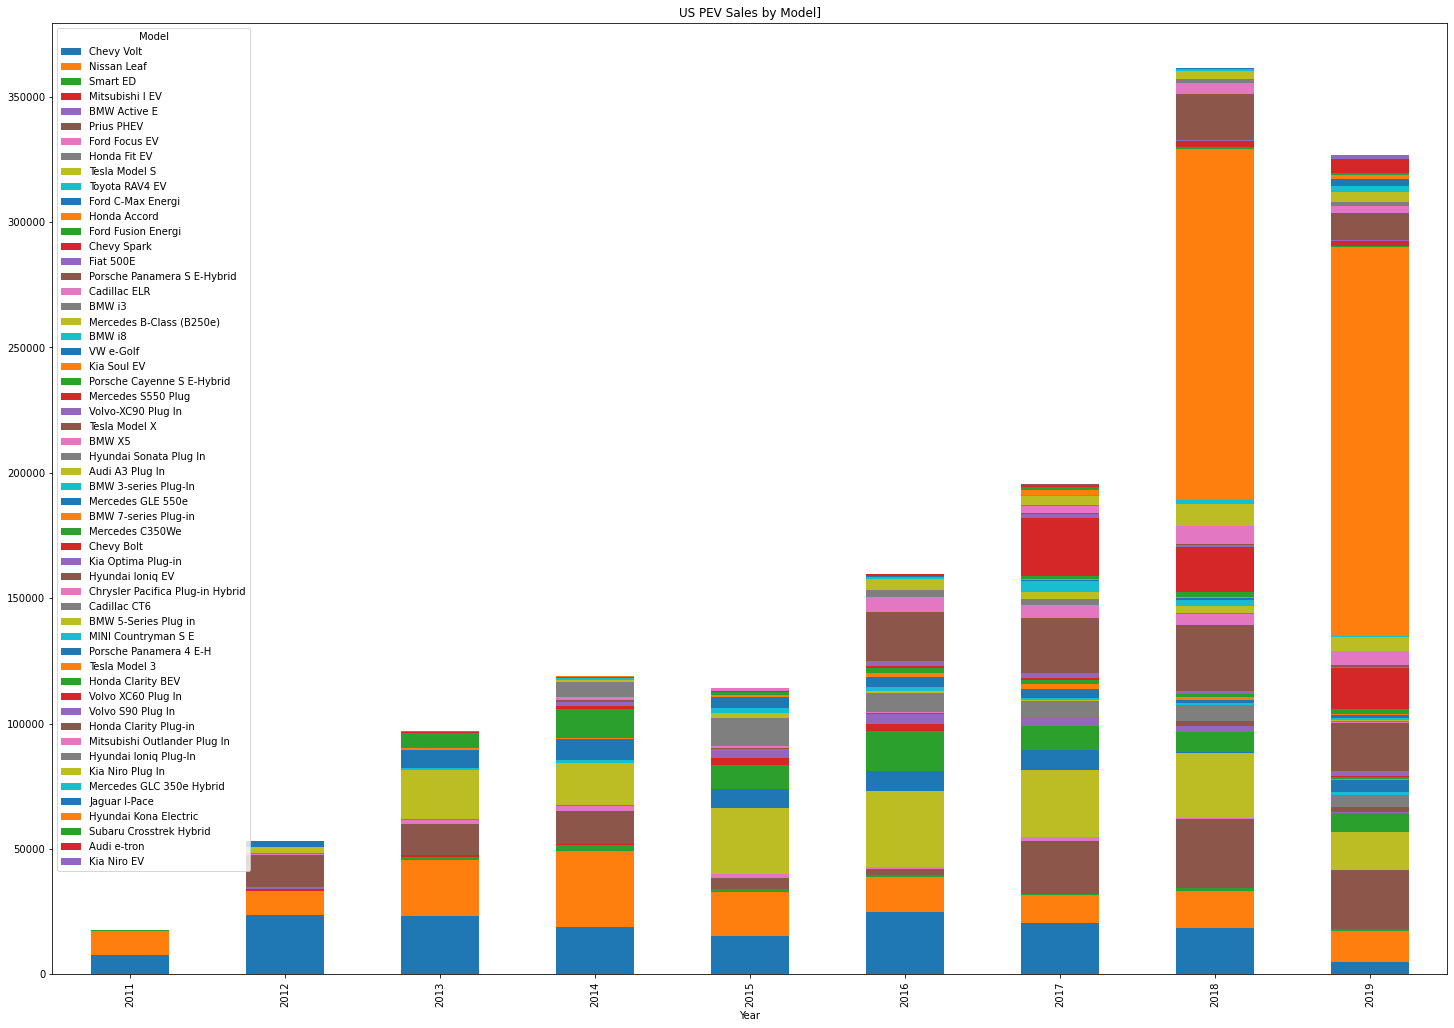

In [30]:
named_pivot_df.plot.bar(stacked=True, figsize=(25,17.5), title = "US PEV Sales by Model]")

# EV Sales Regression Analysis - (Jack)

In [31]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings

In [32]:
# Each model I test throws 6 warnings, due to datatype and some early indexing issues. I test 64 models so this adds up
warnings.filterwarnings("ignore")

# Sets Pandas options to view the whole dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [33]:
def read_n_clean_1(location):
    # Import Data, and drop most columns
    df = pd.read_csv(location, encoding='utf-8')
    df = df.drop(
        columns=['Street Address', 'Intersection Directions', 'City', 'ZIP', 'Plus4', 'Station Phone', 'Status Code',
                 'Groups With Access Code', 'Access Days Time', 'Cards Accepted', 'BD Blends', 'NG Fill Type Code',
                 'NG PSI', 'Geocode Status', 'Latitude', 'Longitude', 'ID', 'Updated At', 'Owner Type Code',
                 'Federal Agency ID', 'Federal Agency Name', 'Hydrogen Status Link', 'NG Vehicle Class', 'LPG Primary',
                 'E85 Blender Pump', 'Intersection Directions (French)', 'Access Days Time (French)',
                 'BD Blends (French)',
                 'Groups With Access Code (French)', 'Hydrogen Is Retail', 'Access Detail Code',
                 'Federal Agency Code', 'EV Pricing (French)', 'LPG Nozzle Types', 'Hydrogen Pressures',
                 'Hydrogen Standards', 'CNG Fill Type Code', 'CNG PSI', 'CNG Vehicle Class', 'LNG Vehicle Class',
                 'EV On-Site Renewable Source', 'Restricted Access', 'CNG Dispenser Num',
                 'CNG On-Site Renewable Source',
                 'CNG Total Compression Capacity', 'CNG Storage Capacity', 'LNG On-Site Renewable Source',
                 'E85 Other Ethanol Blends'])
    return df


In [34]:
def read_n_clean_2(df):
    # Some basic filtering. We only want US data, public access ports, and obviously EV stations. Optional filter for
    # state
    df = df.drop(
        columns=['Station Name', 'Expected Date', 'EV Level1 EVSE Num', 'EV Level2 EVSE Num',
                 'EV DC Fast Count', 'EV Other Info', 'EV Network', 'EV Network Web', 'Date Last Confirmed',
                 'EV Connector Types', 'Facility Type', 'EV Pricing'])

    df = df[df["Fuel Type Code"] == "ELEC"]
    df = df[df['Country'] == 'US']
    df = df[df['Access Code'] == 'public']
    return df

In [35]:
def format_and_summarize(df):
    # Convert Station open date to a Year-Month string, and creates new column Year-Month
    df['Open Date'] = pd.to_datetime(df['Open Date'], format='%Y-%m-%d')
    df['Year-Month'] = df['Open Date'].dt.strftime('%Y-%m')

    # Drops other last set of filter columns. We are just left with Year-Month, also adds Chargepoints, the column we
    # will sum() on when we group by Year-Month
    df = df.drop(columns=['Fuel Type Code', 'Open Date', 'Country', 'Access Code', 'State'])
    df['Chargepoints'] = 1
    df = df.groupby(['Year-Month']).sum()
    return df

In [36]:
def create_model_maker(min, max):
    # Creates a multi nested list for use in ARIMA estimation Models
    m_list = []
    for a in range(min, max + 1):
        for b in range(min, max + 1):
            for c in range(min, max + 1):
                m_list.append([0, [a, b, c]])
    return m_list

In [37]:
def test_models(model_list, train, test):
    # Runs all possible models from model_list.  Scores them on RMSE, and sorts to identify the best model for data
    # model_list: a custom nested list full of models. Created from create_model_maker()
    # train: Training dataset, index and values
    # test: Scoring dataset, index and values

    for model in range(len(model_list)):
        aa = model_list[model][1][0]
        bb = model_list[model][1][1]
        cc = model_list[model][1][2]

        ARIMAmodel = ARIMA(train['Chargepoints'], order=(aa, bb, cc))
        ARIMAmodel = ARIMAmodel.fit()
        y_pred = ARIMAmodel.get_forecast(len(test.index))
        y_pred_df = y_pred.conf_int(alpha=0.05)
        y_pred_df["Predictions"] = ARIMAmodel.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
        y_pred_df.index = test.index
        arma_rmse = np.sqrt(mean_squared_error(test["Chargepoints"].values, y_pred_df["Predictions"]))
        model_list[model][0] = arma_rmse
        print(model_list[model])
        print('Running ARIMA Model # ', model + 1, 'of ', len(model_list))
    model_list.sort(key=lambda x: x[0], reverse=False)
    return model_list

In [38]:
def test_train_date(df, date):
    # Creates training and testing datasets for ARIMA Estimator Model"""
    train = df[df.index <= date]
    test = df[df.index > date]
    return train, test

In [39]:
def print_base_graph(df, filt):
    # Set standards for the first plt.plot(), the reflection of all data
    sns.set()
    plt.tick_params(labelbottom=False, bottom=False)
    plt.xlabel('1995 - 2021 (Monthly)')
    plt.ylabel('EV Stations Opened each Month')
    plt.title("EV Charging Station Growth -> Filters: " + filt)

    # Plots and Shows the charging station built per month over time
    plt.plot(df.index, df['Chargepoints'])
    plt.show()

In [40]:
def add_2022(df):
    # Creates and adds the 2022 year to the Dataframe.
    # 0's are reported as these are the values we will be estimating with our newly found optimal model
    df2 = pd.DataFrame([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], columns=['Chargepoints'],
                       index=['2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08',
                              '2022-09', '2022-10', '2022-10', '2022-12'])
    df = df.append(df2)
    return df

In [41]:
def final_graph(train, model_lst, state_filter):
    # Creates final Graph with optimal model

    # Inputs optimal ARIMA model and fits it to the data
    ARIMAmodel = ARIMA(train['Chargepoints'], order=(model_lst[0][1][0], model_lst[0][1][1], model_lst[0][1][2]))
    ARIMAmodel = ARIMAmodel.fit()

    # The guts of the procedure. Applys model with confidence level of .05,
    y_pred = ARIMAmodel.get_forecast(len(test.index))
    y_pred_df = y_pred.conf_int(alpha=0.05)
    y_pred_df["Predictions"] = ARIMAmodel.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
    y_pred_df.index = test.index
    y_pred_out = y_pred_df["Predictions"]

    # Set standards for the second plt.plot(), with 3 different data sets, the Train, Test, and Estimate
    sns.set()
    plt.tick_params(labelbottom=False, bottom=False)
    plt.xlabel('1995 - 2022 (Monthly)')
    plt.ylabel('EV Stations Opened Each Month')
    plt.title("ARIMA Model Estimates for " + state_filter)

    # Plots and shows the 3 data sets, the Train, Test, and Estimate
    plt.plot(train, color="black", label='1995-2020 Data (Train)')
    plt.plot(test, color="red", label='2020-2020 Data (Test)')
    plt.plot(y_pred_out, color='Green', label='ARIMA Estimate ' + str(omni[0][1]))
    plt.legend()
    plt.show()

In [42]:
"""----Intro Data----"""
Stations = read_n_clean_1("alt_fuel_stations (Dec 7 2021).csv")
Stations = read_n_clean_2(Stations)

state_filter = 'CA'
EV_chargingpoints = Stations[Stations['State'] == state_filter]
EV_chargingpoints = format_and_summarize(EV_chargingpoints)

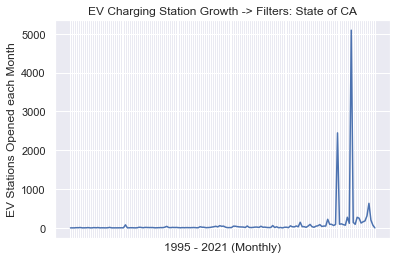

In [43]:
"""----Start Graph 1----"""

print_base_graph(EV_chargingpoints, 'State of ' + state_filter)

In [44]:
"""----Creation & Curation of ARIMA Models----"""
# Creation of Test and Train Datasets,
train, test = test_train_date(EV_chargingpoints, '2020-01')

# Creation of the model training list
omni = create_model_maker(0, 3)

# Run models in list and discover the best model, via RSME
omni = test_models(omni, train, test)

[1161.5853813990004, [0, 0, 0]]
Running ARIMA Model #  1 of  64
[1161.3416807055837, [0, 0, 1]]
Running ARIMA Model #  2 of  64
[1160.9543241557028, [0, 0, 2]]
Running ARIMA Model #  3 of  64
[1160.9767625800462, [0, 0, 3]]
Running ARIMA Model #  4 of  64
[1100.8945226496496, [0, 1, 0]]
Running ARIMA Model #  5 of  64
[1139.9401895719714, [0, 1, 1]]
Running ARIMA Model #  6 of  64
[1139.9038188588727, [0, 1, 2]]
Running ARIMA Model #  7 of  64
[1139.6521606511146, [0, 1, 3]]
Running ARIMA Model #  8 of  64
[2555.823986506147, [0, 2, 0]]
Running ARIMA Model #  9 of  64
[1097.344495396649, [0, 2, 1]]
Running ARIMA Model #  10 of  64
[1125.0287234925383, [0, 2, 2]]
Running ARIMA Model #  11 of  64
[1123.8072846200857, [0, 2, 3]]
Running ARIMA Model #  12 of  64
[26979.295896730662, [0, 3, 0]]
Running ARIMA Model #  13 of  64
[2730.111953420612, [0, 3, 1]]
Running ARIMA Model #  14 of  64
[1133.5527821649646, [0, 3, 2]]
Running ARIMA Model #  15 of  64
[1120.6954743129031, [0, 3, 3]]
Runni

LinAlgError: LU decomposition error.

In [ ]:
"""----Start Graph 2----"""
# Adds in 2022 blanks for model to estimate
EV_chargingpoints = add_2022(EV_chargingpoints)

# re-creates training and testing datasets for ARIMA Estimator Model, now with 2022 blanks
train, test = test_train_date(EV_chargingpoints, '2020-01')

final_graph(train, omni, state_filter)

# Lifetime fuel cost saving analysis - (Nabil)

In [57]:
data_df = pd.read_csv('cost_of_charging_2019.xlsx')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa8 in position 14: invalid start byte

In [61]:
data_df = pd.read_csv('C-PHEV')
data_df=data_df.dropna()

kep = data_df[['state','baseline_lfcs','min_lfcs','max_lfcs']]
print(kep.head(20))

kep.index = kep['state']
kep.plot(figsize=(20,10),kind="bar")

FileNotFoundError: [Errno 2] No such file or directory: 'C-PHEV'